# Setup

In [1]:
import sys
import os


In [2]:
!pip install utm

In [3]:
def is_colab():
    return 'google.colab' in sys.modules

def is_local_windows():
    return os.name == 'nt' and not is_colab()

# Example usage
if is_colab():
    print("Running on Google Colab")
elif is_local_windows():
    print("Running locally on Windows")
else:
    print("Running elsewhere")



if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')

    # base_path = '/content/drive/Othercomputers/המחשב האישי שלי/סמסטר ב 2025/תקשורת וחישה משולבות לשערוך מזג אוויר/מטלה 3/code/PyNNcml'
    base_path = '/content/drive/Othercomputers/המחשב האישי שלי/code/PyNNcml'

    if base_path not in sys.path:
        sys.path.insert(0, base_path)

else:
    if os.path.exists('../../pynncml'):
        print("Import PyNNCML From Local Code")
        sys.path.insert(0, '../../')

Running on Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pickle

# if os.path.exists('../../pynncml'):
#     print("Import PyNNCML From Code")
#     # sys.path.append('../../')  # This line is need to import pynncml
#     sys.path.insert(0, '../../')
# else:
#     print("Install PyNNCML From pip")
#     !pip install pynncml

import numpy as np
import pynncml as pnc
import torch
import math
from matplotlib import pyplot as plt
from tqdm import tqdm
import scipy
from sklearn import metrics
import pandas as pd # Import pandas



In [5]:
print(pnc.__file__)

/content/drive/Othercomputers/המחשב האישי שלי/code/PyNNcml/pynncml/__init__.py


In [123]:
xy_min = [1.29e6, 0.565e6]  # Link Region
xy_max = [1.34e6, 0.5875e6]
time_slice = slice("2015-06-01", "2015-06-10")  # Time Interval
# dataset = pnc.datasets.loader_open_mrg_dataset(data_path=".\\data\\", xy_min=xy_min, xy_max=xy_max, time_slice=time_slice)

# if condition init dataset, else read from pickle
to_load_dataset = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

results_path = "results_files"
# model_path = f"{results_path}/pretrained_model_exp_11.pth"
model_path = f"{results_path}/pretrained_model_exp_21.pth"


#  @title Hyper-parameters
batch_size = 1  # @param{type:"integer"}
window_size = 32  # @param{type:"integer"}
rnn_n_features = 128  # @param{type:"integer"}
rnn_input_size = 180
metadata_n_features = 32  # @param{type:"integer"}
metadata_n_hidden = 1
n_layers = 2  # @param{type:"integer"}
rnn_type = pnc.neural_networks.RNNType.GRU  # RNN Type

n_geofeatures = 5

# use for given example
example_index_to_use = 0 # Use the first example
step_index_to_use = 0   # Use the first step (first window_size samples)


In [124]:
import os

try:
    # In Colab, __file__ is often not set, and the working directory is the notebook's directory.
    # If it's not, we can try to infer it from the base_path we defined earlier if running in Colab.
    if is_colab():
        notebook_dir = os.path.dirname(base_path + '/examples/tutorials/data_driven_tutorial.ipynb')
        if os.path.exists(notebook_dir):
             print(f"Changing directory to {notebook_dir}")
             os.chdir(notebook_dir)
        else:
            print(f"Could not find notebook directory based on base_path: {notebook_dir}")
            print("Current working directory:", os.getcwd())
    else:
         # In other environments, the working directory is often the notebook's directory by default.
         # If not, we can try to get the path of the currently executing script (which is this notebook).
         # However, getting the path of a running notebook reliably is tricky.
         # A common workaround is to explicitly set the directory.
         print("Assuming working directory is the notebook's directory or manually set.")
         print("Current working directory:", os.getcwd())

except NameError:
    print("Could not automatically determine notebook directory.")
    print("Current working directory:", os.getcwd())

print("Current working directory after change attempt:", os.getcwd())

Changing directory to /content/drive/Othercomputers/המחשב האישי שלי/code/PyNNcml/examples/tutorials
Current working directory after change attempt: /content/drive/Othercomputers/המחשב האישי שלי/code/PyNNcml/examples/tutorials


In [125]:
# Check if pickle file exists
pickle_path = "dataset.pkl"
if to_load_dataset==False:
    # Initialize dataset from loader
    print("Initializing dataset from loader...")
    dataset = pnc.datasets.loader_open_mrg_dataset(data_path=".\\data\\", xy_min=xy_min, xy_max=xy_max, time_slice=time_slice)

    # Save dataset to pickle
    with open(pickle_path, 'wb') as f:
        pickle.dump(dataset, f)
    print(f"Dataset saved to {pickle_path}")
elif to_load_dataset:
    # Load dataset from pickle
    print(f"Loading dataset from {pickle_path}...")
    with open(pickle_path, 'rb') as f:
        dataset = pickle.load(f)
    print("Dataset loaded successfully")


Loading dataset from dataset.pkl...
Dataset loaded successfully


# Load model

In [126]:
training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
data_loader = torch.utils.data.DataLoader(training_dataset, batch_size)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size)

In [127]:
model = pnc.scm.rain_estimation.two_step_network(
            n_layers=n_layers,  # Number of RNN layers
            rnn_type=rnn_type,  # Type of RNN (GRU, LSTM)
            normalization_cfg=pnc.training_helpers.compute_data_normalization(data_loader),  # Compute the normalization statistics from the training dataset.
            rnn_input_size=rnn_input_size,  # 180,  # 90 + 90 (RSL + TSL)
            rnn_n_features=rnn_n_features,  # Number of features in the RNN
            metadata_input_size=len(dataset[0][-1]),  # Number of metadata features
            metadata_n_features=metadata_n_features,
            metadata_n_hidden=metadata_n_hidden,  # Number of hidden layers in the metadata block
            # New parameters available in the constructor:
            metadata_feature_mask=None,
            freeze_rnn=False,
            model_file_path=model_path,
            pretrained=True
        ).to(device)

model.eval()

TwoStepNetwork(
  (bb): Backbone(
    (rnn): GRU(180, 128, num_layers=2, batch_first=True)
    (metadata_block): MetadataFCBlock(
      (metadata_block): Sequential(
        (0): Linear(in_features=7, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      )
    )
    (normalization): InputNormalization()
    (relu): ReLU()
  )
  (rh): RainHead(
    (fc): Linear(in_features=160, out_features=1, bias=True)
  )
  (wdh): WetDryHead(
    (fc): Linear(in_features=160, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)

# Load link example

Link metadata is (frequency, length [km], gauge_dist_rel, cos_theta, sin_theta, rel_x_norm, rel_y_norm)

In [128]:
example_index = example_index_to_use
example = dataset[example_index]
print(f"{len(example) = }")
rain_rate, rsl, tsl, metadata = example
length = metadata[1]
print(f"link lenght = {length}")
print(f"{len(metadata) = }")

example_link = dataset.link_set.get_link(example_index)

len(example) = 4
link lenght = 1.1822700500488281
len(metadata) = 7


# Create Grid and Show Geofeatures

In [129]:
def create_grid(width, height, spacing):
  x = np.arange(-width , width, spacing)
  y = np.arange(-height, height, spacing)
  xv, yv = np.meshgrid(x, y)
  grid = np.vstack([xv.ravel(), yv.ravel()]).T
  return grid

grid_dimensions = (5000, 3000)  # Width and height of the grid
grid_spacing = 100      # Spacing between grid points
grid_points = create_grid(*grid_dimensions, grid_spacing)
print("Shape of the grid:", grid_points.shape)

grid_geofeatures = np.zeros((grid_points.shape[0], n_geofeatures))
print(f"{grid_geofeatures.shape = }")

for i, point in enumerate(grid_points):
  grid_geofeatures[i] = example_link.compute_geo_features(np.array([0,-length*1000/2]), np.array([0, length*1000/2]), np.array(point))
  aligned_features = np.concatenate(
            (np.asarray([example_link.meta_data.frequency, example_link.meta_data.length]).astype("float32"),
             grid_geofeatures[i].astype("float32")),
            axis=0
        )

Shape of the grid: (6000, 2)
grid_geofeatures.shape = (6000, 5)


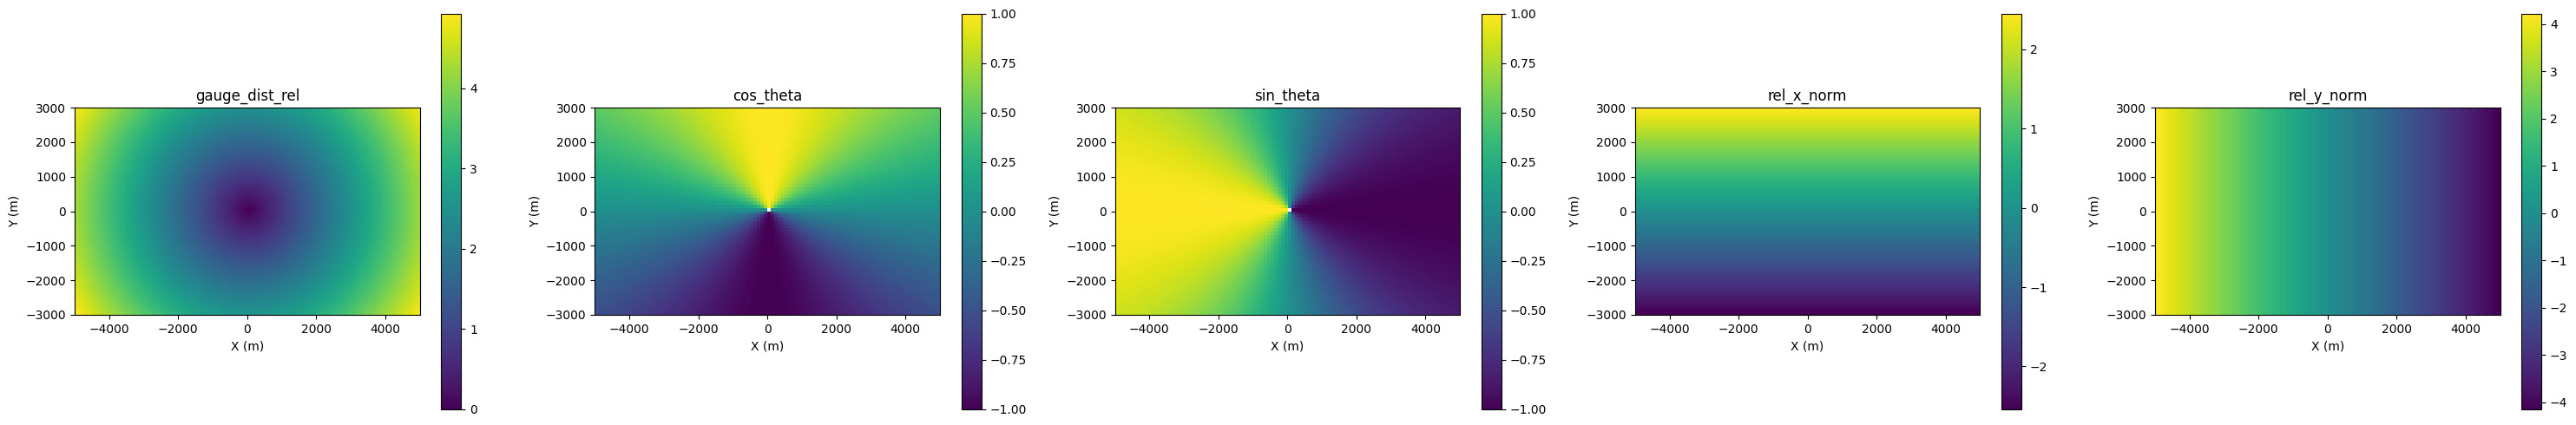

In [130]:
titles = ["gauge_dist_rel", "cos_theta", "sin_theta", "rel_x_norm", "rel_y_norm"]
fig, axes = plt.subplots(1, n_geofeatures, figsize=(30, 5))

for i in range(n_geofeatures):
    feature_values = grid_geofeatures[:, i].reshape(int(2*grid_dimensions[1]/grid_spacing), int(2*grid_dimensions[0]/grid_spacing))
    im = axes[i].imshow(feature_values, origin='lower', extent=[-grid_dimensions[0], grid_dimensions[0], -grid_dimensions[1], grid_dimensions[1]])
    axes[i].set_title(f'{titles[i]}')
    axes[i].set_xlabel('X (m)')
    axes[i].set_ylabel('Y (m)')
    fig.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()


# Example of running the model on a signle section

In [131]:
# model.eval()
# # ga = pnc.analysis.GroupAnalysis()
# ga = pnc.metrics.GroupAnalysis()
# with torch.no_grad():
#     for rain_rate, rsl, tsl, metadata in val_loader:
#         state = model.init_state(batch_size=rsl.shape[0])
#         m_step = math.floor(rain_rate.shape[1] / window_size)
#         # am.clear()
#         rain_ref_list = []
#         rain_hat_list = []
#         detection_list = []

#         for step in range(m_step):
#             _rr = rain_rate[:, step * window_size:(step + 1) * window_size].float().to(device)
#             _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
#             _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
#             rain_estimation_detection, state = model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device),
#                                                      state.detach())
#             rain_detection = rain_estimation_detection[:, :, 1]
#             rain_hat = rain_estimation_detection[:, :, 0] * torch.round(
#                 rain_detection)  # Rain Rate is computed only for wet samples
#             rain_hat_list.append(rain_hat.detach().cpu().numpy())
#             rain_ref_list.append(_rr.detach().cpu().numpy())
#             ga.append(rain_ref_list[-1], rain_hat_list[-1])
#             detection_list.append(torch.round(rain_detection).detach().cpu().numpy())
#             delta = rain_hat.squeeze(dim=-1) - _rr
#             bias = torch.mean(delta)
#             mse = torch.mean(delta ** 2)
#             # am.add_results(bias=bias.item(), mse=mse.item())
# # actual = np.concatenate(detection_list).flatten()
# # predicted = (np.concatenate(rain_ref_list) > 0.1).astype("float").flatten()
# predicted = np.concatenate(detection_list).flatten()
# actual = (np.concatenate(rain_ref_list) > 0.1).astype("float").flatten()
# confusion_matrix = metrics.confusion_matrix(actual, predicted)
# max_rain = np.max(np.concatenate(rain_ref_list))
# g_array = np.linspace(0, max_rain, 6)

# print("Results Detection:")
# print("Validation Results of Two-Step RNN")
# print("Accuracy[%]:", 100 * (np.sum(actual == predicted) / actual.size))
# print("F1 Score:", metrics.f1_score(actual, predicted))
# print("Precision:", metrics.precision_score(actual, predicted))
# print("Recall:", metrics.recall_score(actual, predicted))

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])

# cm_display.plot()
# plt.show()

# print("Results Estimation:")
# _ = ga.run_analysis(np.stack([g_array[:-1], g_array[1:]], axis=-1))


In [132]:
# detection_array = np.concatenate(detection_list, axis=1)
# rain_ref_array = np.concatenate(rain_ref_list, axis=1)
# detection_array = np.round(detection_array)

# rain_array = rain_ref_array[0, :300]
# detection_array = detection_array[0, :300]
# fig, ax = plt.subplots()
# x = np.arange(rain_array.shape[0])
# ax.plot(x, rain_array, label="Rain")
# rain_max = np.max(rain_array)
# ax.fill_between(x, rain_max, where=np.logical_or(np.logical_and(detection_array == 1, rain_array > 0),
#                                                  np.logical_and(detection_array == 0, rain_array == 0)),
#                                                  facecolor='green', alpha=.5, label="Detection")
# ax.fill_between(x, rain_max, where=np.logical_and(detection_array == 0, rain_array > 0), facecolor='red',
#                 alpha=.5, label="Mis-Detection")
# ax.fill_between(x, rain_max, where=np.logical_and(detection_array == 1, rain_array == 0), facecolor='blue',
#                 alpha=.5, label="False Alarm")
# plt.legend()
# plt.ylabel("Rain Rate [mm/hr]")
# plt.xlabel("Sample Index")
# plt.grid()
# plt.show()

In [133]:
# # get rain estimation and detection from model output
# rain_hat = rain_estimation_detection[:, :, 0].squeeze(0).detach().cpu().numpy()
# rain_detection_scores = rain_estimation_detection[:, :, 1].squeeze(0).detach().cpu().numpy()

# # gt rain
# rain_ref = _rr.squeeze(0).detach().cpu().numpy()
# # classification
# rain_detection_binary = np.round(rain_detection_scores)
# # mask rain rate with binary detection
# rain_hat_detected = rain_hat * rain_detection_binary
# # create a time axis for the window
# time_steps = np.arange(window_size)

# plt.figure(figsize=(12, 6))
# # plot ground truth rain rate
# plt.plot(time_steps, rain_ref, label='Ground Truth Rain Rate', marker='o', linestyle='-')
# # plot estimated rain rate before detection
# plt.plot(time_steps, rain_hat, label='Estimated Rain Rate (before detection)', marker='x', linestyle='--')
# # plot estimated rain rate after applying detection
# plt.plot(time_steps, rain_hat_detected, label='Estimated Rain Rate (after detection)', marker='s', linestyle='-.')


# # plot detection scores and binary detection
# # For simplicity, let's visualize the binary detection as shaded regions
# # zero areas where rain was detected by the model
# plt.fill_between(time_steps, plt.ylim()[0], plt.ylim()[1], where=rain_detection_binary > 0.5, color='green', alpha=0.2, label='Model Detected Wet')
# # zero areas where ground truth rain is present but model did not detect
# plt.fill_between(time_steps, plt.ylim()[0], plt.ylim()[1], where=(rain_ref > 0.1) & (rain_detection_binary < 0.5), color='red', alpha=0.3, label='Mis-Detection')
# # zero areas where model detected wet but ground truth is dry
# plt.fill_between(time_steps, plt.ylim()[0], plt.ylim()[1], where=(rain_ref <= 0.1) & (rain_detection_binary > 0.5), color='blue', alpha=0.3, label='False Alarm')


# plt.xlabel('Time Step within Window')
# plt.ylabel('Rain Rate [mm/hr]')
# plt.title('Rain Estimation and Detection for a Single Example and Step')
# plt.legend()
# plt.grid(True)
# plt.show()

# # plot the detection scores separately if desired
# plt.figure(figsize=(12, 3))
# plt.plot(time_steps, rain_detection_scores, label='Detection Score', marker='.', linestyle='-')
# plt.plot(time_steps, rain_detection_binary, label='Binary Detection (Rounded Score)', marker='.', linestyle='--')
# plt.xlabel('Time Step within Window')
# plt.ylabel('Detection Score')
# plt.title('Detection Scores for a Single Example and Step')
# plt.legend()
# plt.grid(True)
# plt.show()

# Compute Rain Rate on grid for given example and step

In [134]:
def compute_masked_rain_sum(model, dataset, example_index, step_index, override_metadata=None):
    """
    Computes the sum of the estimated rain rate for a specified step for an example in the dataset.
    """
    # Get the device from the model's parameters
    model_device = next(model.parameters()).device
    # input data
    rain_rate_data, rsl_data, tsl_data, metadata_data = dataset[example_index]

    # handle metadata
    if override_metadata is None:
        metadata_batch = torch.tensor(metadata_data).unsqueeze(0)
    else:
        metadata_batch = override_metadata

    metadata_batch = metadata_batch.to(model_device)

    # get data for the given step
    start_index = step_index * window_size
    end_index = start_index + window_size
    rsl_tensor = torch.tensor(rsl_data[start_index:end_index]).unsqueeze(0).to(model_device)
    tsl_tensor = torch.tensor(tsl_data[start_index:end_index]).unsqueeze(0).to(model_device)

    state = model.init_state(batch_size=1).to(model_device)

    # run model inference
    with torch.no_grad():
        model_input = torch.cat([rsl_tensor, tsl_tensor], dim=-1)
        rain_estimation_detection, state = model(model_input, metadata_batch, state.detach())

    # get rain estimation and detection scores
    # model output shape = (batch_size, window_size, 2)
    rain_estimation = rain_estimation_detection[:, :, 0] # shape (1, window_size)
    detection_scores = rain_estimation_detection[:, :, 1] # shape (1, window_size)
    # apply detection threshold to get binary detection
    binary_detection = torch.round(detection_scores) # shape (1, window_size)
    # apply the binary detection mask to the rain estimation and compute the sum
    sum_masked_rain = torch.sum(rain_estimation * binary_detection).item()

    return sum_masked_rain

# Compute the sum using the function
masked_rain_sum = compute_masked_rain_sum(model, dataset, example_index_to_use, step_index_to_use)

print(f"Sum of masked estimated rain rate for example {example_index_to_use}, step {step_index_to_use}: {masked_rain_sum}")

# Example usage with override metadata (optional)
# Let's create some dummy override metadata with the correct shape
# Ensure dummy_override_metadata is on the same device as the model
# dummy_override_metadata = torch.randn(1, len(dataset[0][-1])).to(next(model.parameters()).device)
# masked_rain_sum_override = compute_masked_rain_sum(model, dataset, example_index_to_use, step_index_to_use, override_metadata=dummy_override_metadata)

# print(f"Sum of masked estimated rain rate with override metadata: {masked_rain_sum_override}")

Sum of masked estimated rain rate for example 0, step 0: 27.821779251098633


## Init parameters

In [149]:
example_index_for_grid = example_index_to_use # Use the same example index as before
step_index_for_grid = step_index_to_use     # Use the same step index as before

print(f"{example_index_for_grid=}")
print(f"{step_index_for_grid=}")

# get link object
example_link_for_grid = dataset.link_set.get_link(example_index_for_grid)
example_link_2 = dataset.link_set.get_link(example_index_to_use+2)


print(f"{example_link_for_grid.meta_data.length =}")
print(f"{example_link_2.meta_data.length =}")

example_index_for_grid=0
step_index_for_grid=0
example_link_for_grid.meta_data.length =1.18227
example_link_2.meta_data.length =0.36201


In [150]:
num_grid_points = grid_points.shape[0]
grid_rain_estimation_sum = np.zeros(num_grid_points)
print(f"{grid_rain_estimation_sum.shape=}")

grid_rain_estimation_sum.shape=(6000,)


## Create the grid

In [151]:
def create_grid(width, height, spacing):
  x = np.arange(-width , width, spacing)
  y = np.arange(-height, height, spacing)
  xv, yv = np.meshgrid(x, y)
  grid = np.vstack([xv.ravel(), yv.ravel()]).T
  return grid

# assuming grid_dimensions and grid_spacing are from before
# grid_dimensions = (5000, 3000)
# grid_spacing = 100

grid_points = create_grid(*grid_dimensions, grid_spacing)
print("Shape of the grid:", grid_points.shape)

# n_geofeatures defined in the start
grid_geofeatures = np.zeros((grid_points.shape[0], n_geofeatures))
print(f"{grid_geofeatures.shape = }")

Shape of the grid: (6000, 2)
grid_geofeatures.shape = (6000, 5)


## Fill rain values on grid

In [158]:
# assuming model, dataset, example_index_for_grid, step_index_for_grid,
# compute_masked_rain_sum, window_size, and example_link_for_grid are from before
length = example_link_for_grid.meta_data.length
# length = example_link_2.meta_data.length

num_grid_points = grid_points.shape[0]
grid_rain_estimation_sum = np.zeros(num_grid_points)

# iterate through each point in the grid_points array and compute the masked rain sum
for i, point in enumerate(tqdm(grid_points, desc="Processing Grid Points")):
    # Compute the geo-features for the current grid point relative to the link
    # assume link is at the center of the grid
    point_geofeatures = example_link_for_grid.compute_geo_features(
        np.array([0,-length*1000/2]),  # Link start relative to center
        np.array([0, length*1000/2]),   # Link end relative to center
        np.array(point)
    )

    current_metadata = np.concatenate([
        np.asarray([example_link_for_grid.meta_data.frequency, length]).astype("float32"),
        point_geofeatures.astype("float32")
    ], axis=0)
    current_metadata_tensor = torch.tensor(current_metadata).unsqueeze(0)

    # use the compute_masked_rain_sum function with the override metadata
    masked_rain_sum_for_point = compute_masked_rain_sum(
        model=model,
        dataset=dataset,
        example_index=example_index_for_grid,
        step_index=step_index_for_grid,
        override_metadata=current_metadata_tensor
    )
    grid_rain_estimation_sum[i] = masked_rain_sum_for_point

# reshape the results into a grid format for plotting
grid_rain_estimation_sum_reshaped = grid_rain_estimation_sum.reshape(
    int(2 * grid_dimensions[1] / grid_spacing),
    int(2 * grid_dimensions[0] / grid_spacing)
)

print(f"\n{grid_rain_estimation_sum_reshaped.shape=}")

Processing Grid Points: 100%|██████████| 6000/6000 [00:31<00:00, 192.46it/s]


grid_rain_estimation_sum_reshaped.shape=(60, 100)


## Plot Grid

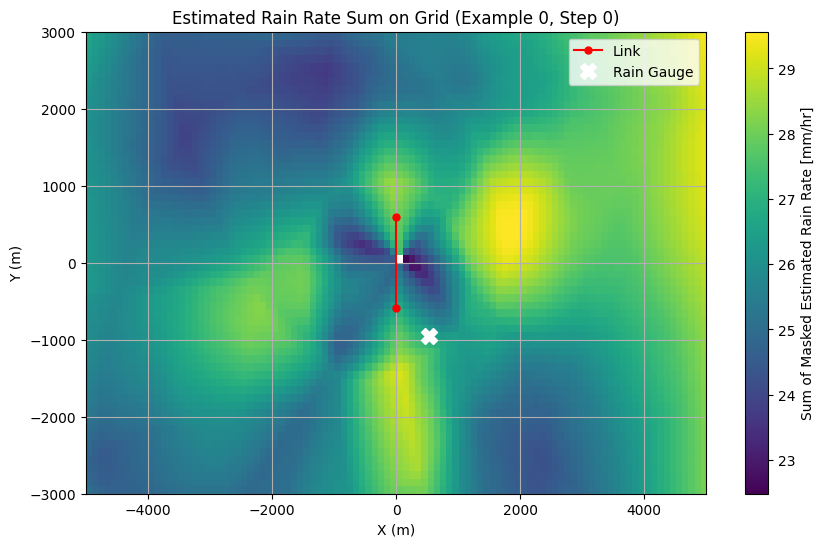

In [159]:
# Plot the reshaped masked rain sum as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(grid_rain_estimation_sum_reshaped, origin='lower',
           extent=[-grid_dimensions[0], grid_dimensions[0], -grid_dimensions[1], grid_dimensions[1]],
           aspect='auto', cmap='viridis') # Use a suitable colormap
plt.colorbar(label='Sum of Masked Estimated Rain Rate [mm/hr]')
plt.title(f'Estimated Rain Rate Sum on Grid (Example {example_index_for_grid}, Step {step_index_for_grid})')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

link_length_meters = example_link_for_grid.meta_data.length * 1000

# plot the link at the center of the grid
plt.plot([0, 0],
         [-link_length_meters / 2, link_length_meters / 2],
         'ro-', markersize=5, label='Link')

gauge_geometric_features = example_link_for_grid.compute_geo_features()

# reconstruct gauge position from geoparameters
gauge_rel_x_norm = gauge_geometric_features[3] # index 3 is rel_x_norm
gauge_rel_y_norm = gauge_geometric_features[4] # index 4 is rel_y_norm
# undo scaling
gauge_plot_x = gauge_rel_x_norm * link_length_meters
gauge_plot_y = gauge_rel_y_norm * link_length_meters

plt.plot(gauge_plot_x, gauge_plot_y, 'wX', markersize=12, label='Rain Gauge') # Green X marker


plt.legend()
plt.grid(True)
plt.show()

# Summarize results from files in tables

In [51]:
def results_from_file(model_type, exp_num, folder_path=results_path):
  """
  Read results from file.
  Possible types are "pretrain", "geo", masked"
  """
  # Open the file in read binary mode ("rb") instead of write binary mode ("wb")
  file_name = f"{folder_path}/{model_type}_results_exp_{exp_num}.pkl"
  # print(file_name)
  # print(os.path.exists(file_name), os.path.getsize(file_name))
  with open(file_name, "rb") as f:
    res = pickle.load(f)
  # add values of last indices on list
  res["final_loss"] = res["loss"][-1]
  res["final_loss_est"] = res["loss_est"][-1]
  res["final_loss_detection"] = res["loss_detection"][-1]
  return res


# example
out = results_from_file("pretrain", 5)

In [101]:
from google.colab import data_table

data_table.disable_dataframe_formatter()

experiments_to_load = [12,
                       6,
                       9,
                       10,
                       11,
                       13,
                       22,
                       20,
                       21,
                       23]
experiments_goals = ["Baseline",
                     "Medium RNN",
                     "Small RNN",
                     "Pretrain Zero Features",
                     "Pretrain All Features",
                     "Pretrain All Features, Abs Metadata",
                     "Baseline w. est measures",
                     "Pretrain Zero Features w. est measures",
                     "Pretrain All Features w. est measures",
                     "Pretrain All Features, Abs Metadata w. est measures"]
experiments_order = [0, 1, 2, 30, 10, 20, 0, 30, 10, 20]

types_to_load = ["pretrain", "geo", "masked"]

# Initialize an empty list to store the results dictionaries
results_list = []

for i, exp_num in enumerate(experiments_to_load):
  for type_to_load in types_to_load:
    try:
      out = results_from_file(type_to_load, exp_num)
      # Add 'model_type' and 'exp_num' to the dictionary for identification
      out['model_type'] = type_to_load
      out['exp_num'] = exp_num
      out['goal'] = experiments_goals[i]
      out['order'] = experiments_order[i]
      # Append the dictionary to the list
      results_list.append(out)
    except FileNotFoundError:
      print(f"Warning: File not found for type '{type_to_load}', experiment {exp_num}. Skipping.")
    except EOFError:
      print(f"Warning: EOFError reading file for type '{type_to_load}', experiment {exp_num}. File might be empty or corrupt. Skipping.")
    except Exception as e:
      print(f"An unexpected error occurred for type '{type_to_load}', experiment {exp_num}: {e}. Skipping.")


# Create a pandas DataFrame from the list of dictionaries
results_df = pd.DataFrame(results_list)

# Display the resulting DataFrame
# display(results_df)

In [105]:
# slice to exps 12, 6, (9?) masked, geo - affect of network size (big (original), medium, small)
sizes_df = results_df[results_df["model_type"].isin(["masked", "geo"])]
sizes_df = sizes_df[sizes_df['exp_num'].isin([22, 6, 9])]
sizes_df.sort_values(by='order', inplace=True)
sizes_df['goal'] = sizes_df['goal'].apply(lambda x: x.replace(" w. est measures", ""))

print("sizes_df")
# print(sizes_df.iloc[:, 3:])
# display(sizes_df[['exp_num', 'goal', 'model_type', 'f1_score', 'nbias', 'nrmse', 'precision', 'recall']])
display(sizes_df[['exp_num', 'goal', 'model_type', 'f1_score']])


# slice to exps, 12, 10, 11, 13 - pretrain - affect of with, partial, without features, absolute value
pretrain_df = results_df[results_df["model_type"] == "pretrain"]
pretrain_df = pretrain_df[pretrain_df['exp_num'].isin([22, 20, 21, 23])]
pretrain_df['goal'] = pretrain_df['goal'].apply(lambda x: x.replace(" w. est measures", ""))
pretrain_df.sort_values(by='order', inplace=True)
print("pretrain_df")
# print(pretrain_df.iloc[:, 3:])
display(pretrain_df[['exp_num', 'goal', 'f1_score', 'nbias', 'nrmse', 'precision', 'recall']])


sizes_df


,exp_num,goal,model_type,f1_score
20,22,Baseline,masked,0.773333
19,22,Baseline,geo,0.773333
4,6,Medium RNN,geo,0.500800
5,6,Medium RNN,masked,0.500800
8,9,Small RNN,masked,0.185468
7,9,Small RNN,geo,0.185468


pretrain_df


,exp_num,goal,f1_score,nbias,nrmse,precision,recall
18,22,Baseline,0.772793,-0.00,3.07,0.817764,0.732510
24,21,Pretrain All Features,0.718799,0.34,2.48,0.847300,0.624143
27,23,"Pretrain All Features, Abs Metadata",0.718676,0.26,2.65,0.844444,0.625514
21,20,Pretrain Zero Features,0.503006,0.34,3.59,0.933086,0.344307
